<font size="6"> **Factors and Features** </font>

Run notebook on quant-ai4trading environment


* Alpha Factors
* Universal Quant Features
* Time-based features
* Sector

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import os

import numpy as np
import scipy

from  src import utils
from src.data import read_utils
from src.mle_quant_utils import quant_helper, quant_factors

In [4]:
from zipline.data import bundles
from zipline.utils.calendars import get_calendar
from zipline.pipeline.factors import AverageDollarVolume, Returns, DailyReturns, SimpleMovingAverage, AnnualizedVolatility, CustomFactor
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline import Pipeline
from zipline.data.data_portal import DataPortal


import alphalens as al

In [5]:
cfg = utils.read_conf()

BUNDLE_FOLDER = cfg['quantopian']['dataset3']['bundle_folder']
BUNDLE_NAME = cfg['quantopian']['dataset3']['bundle_name']
SECTOR_FOLDER = cfg['quantopian']['dataset3']['sector_folder']
SECTOR_DATA = cfg['quantopian']['dataset3']['sector_data']
SECTOR_NAMES = cfg['quantopian']['dataset3']['sector_names']

# Specify the bundle path
bundle_path = os.path.join(read_utils.raw_path, 'market_data', BUNDLE_FOLDER)
sector_path = os.path.join(read_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_DATA)
sector_file = os.path.join(read_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)
os.path.isdir(bundle_path)

True

In [6]:
window = int(cfg['models']['universe']['window'])
adv_top = int(cfg['models']['universe']['adv_top'])
univ_start = cfg['models']['universe']['start']

In [7]:
# Data Bundle
os.environ['ZIPLINE_ROOT'] = bundle_path
ingest_func = bundles.csvdir.csvdir_equities(['daily'], BUNDLE_NAME)
bundles.register(BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


In [8]:
sector = quant_helper.get_sectors(sector_path)

In [9]:
universe = AverageDollarVolume(window_length=window).top(adv_top) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(BUNDLE_NAME)
engine = quant_helper.build_pipeline_engine(bundle_data, trading_calendar)

In [10]:
universe_end_date = pd.Timestamp(univ_start, tz='UTC')
factor_start_date = universe_end_date - pd.DateOffset(years=3, days=2)

In [11]:
pipeline = Pipeline(screen=universe)

# Alpha Factors
* 1 year momentum
* 5 day momentum
* overnight returns

In [12]:
# 1yr returns
def momentum(window_length, universe, sector):
    """
    Higher past 12-month (252 days) returns are proportional to future return
    
    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def momentum_smoothed(window_length, smooth_window_length, universe, sector):
    """
    Smoothed version of momentum. window_lenghth is used in returns and smoothing computations
     Parameters
    ----------
    smooth_window_length : int
        smoothing factor to applie to SimpleMovingAverage
    """
    unsmoothed_factor = momentum(window_length, universe, sector)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=smooth_window_length) \
        .rank() \
        .zscore()

In [13]:
# 5d returns
def mean_reversion_sector_neutral(window_length, universe, sector):
    """
    Short-term outperformers(underperformers) compared to their sector will revert.
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    return -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank(method='ordinal', ascending=True) \
        .zscore()


def mean_reversion_sector_neutral_smoothed(window_length, universe, sector):
    """
    Smoothed version of mean_reversion_5day_sector_neutral. window_lenghth is used in returns and smoothing computations
    """
    unsmoothed_factor = mean_reversion_sector_neutral(window_length, universe, sector)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=window_length) \
        .rank() \
        .zscore()


In [14]:
# Overnight returns
class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)
        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()


In [15]:
pipeline.add(
    momentum(252, universe, sector),
    'Momentum_1YR')

pipeline.add(
    momentum_smoothed(252, 5, universe, sector),
    'Momentum_1YR_Smoothed')

In [16]:
pipeline.add(
    mean_reversion_sector_neutral(5, universe, sector),
    'Mean_Reversion_Sector_Neutral')

pipeline.add(
    mean_reversion_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_Sector_Neutral_Smoothed')

In [17]:
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')

# Quant Features
* Stock volatility
* Average dollar volume

Stock volatility: zipline has a custom factor called AnnualizedVolatility.  The [source code is here](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/factors/basic.py) and also pasted below:

```python 
class AnnualizedVolatility(CustomFactor):
    """
    Volatility. The degree of variation of a series over time as measured by
    the standard deviation of daily returns.
    https://en.wikipedia.org/wiki/Volatility_(finance)
    **Default Inputs:** :data:`zipline.pipeline.factors.Returns(window_length=2)`  # noqa
    Parameters
    ----------
    annualization_factor : float, optional
        The number of time units per year. Defaults is 252, the number of NYSE
        trading days in a normal year.
    """
    inputs = [Returns(window_length=2)]
    params = {'annualization_factor': 252.0}
    window_length = 252

    def compute(self, today, assets, out, returns, annualization_factor):
        out[:] = nanstd(returns, axis=0) * (annualization_factor ** .5)
```

In [18]:
pipeline.add(AnnualizedVolatility(window_length=20, mask=universe).rank().zscore(), 'volatility_20d')
pipeline.add(AnnualizedVolatility(window_length=120, mask=universe).rank().zscore(), 'volatility_120d')
pipeline.add(AverageDollarVolume(window_length=20, mask=universe).rank().zscore(), 'adv_20d')
pipeline.add(AverageDollarVolume(window_length=120, mask=universe).rank().zscore(), 'adv_120d')

# Regime Features
* Market dispersion
* Market volatility


Capture market-wide regimes (look at the aggregate movement of the universe of stocks).These features are not evaluated with alphalens as they describe broad market conditions. 

## Market dispersion feature
High and low dispersion: dispersion is looking at the dispersion (standard deviation) of the cross section of all stocks at each period of time (on each day). Inherit from [CustomFactor](http://www.zipline.io/appendix.html?highlight=customfactor#zipline.pipeline.CustomFactor).  Feed in [DailyReturns](http://www.zipline.io/appendix.html?highlight=dailyreturns#zipline.pipeline.factors.DailyReturns) as the `inputs`. 

Create a class that inherits from `CustomFactor`.  Override the `compute` function to calculate the population standard deviation of all the stocks over a specified window of time.

$$\mu = \sum_{t=0}^{T}\sum_{i=1}^{N}r_{i,t}$$

$$\sqrt{\frac{1}{T} \sum_{t=0}^{T}  \frac{1}{N}\sum_{i=1}^{N}(r_{i,t} - \mu)^2}$$

Use [numpy.nanmean](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.nanmean.html) to calculate the average market return $\mu$ and to calculate the average of the squared differences.


In [19]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        
        # calculate average returns to simulate market as an equal weighted portfolio
        mean_returns = np.nanmean(returns)
        
        # calculate standard deviation of returns
        out[:] = np.sqrt(np.nanmean((returns - mean_returns)**2))

In [20]:
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=20), 'dispersion_20d')
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion_120d')


## Market volatility feature 
Class for market volatility, which inherits from [CustomFactor](http://www.zipline.io/appendix.html?highlight=customfactor#zipline.pipeline.CustomFactor).  This will measure the standard deviation of the returns of the "market".  In this case, "market" is approximated as the equal weighted average return of all the stocks in the stock universe.

#### Market return
$$r_{m,t} = \frac{1}{N}\sum_{i=1}^{N}r_{i,t}$$ for each day $t$ in `window_length`.  

#### Average market return
Also calculate the average market return over the `window_length` $T$ of days:  
$$\mu_{m} = \frac{1}{T}\sum_{t=1}^{T} r_{m,t}$$

#### Standard deviation of market return
Then calculate the standard deviation of the market return  
$$\sigma_{m,t} = \sqrt{252 \times \frac{1}{N} \sum_{t=1}^{T}(r_{m,t} - \mu_{m})^2 } $$

In [21]:
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True
    params = {'annualization_factor': 252.0}
    
    def compute(self, today, assets, out, returns, annualization_factor):
        
        """ 
        For each row (each row represents one day of returns), 
        calculate the average of the cross-section of stock returns
        So that market_returns has one value for each day in the window_length
        So choose the appropriate axis (please see hints above)
        """
        mkt_returns = np.nanmean(returns, axis=1) 
        
        # Calculate the mean of market returns
        mkt_returns_mu = np.nanmean(mkt_returns)

        # Calculate the standard deviation of the market returns, then annualize them.
        out[:] = np.sqrt(annualization_factor * np.nanmean((mkt_returns-mkt_returns_mu)**2))

In [22]:
pipeline.add(MarketVolatility(window_length=20), 'market_vol_20d')
pipeline.add(MarketVolatility(window_length=120), 'market_vol_120d')

In [23]:
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)
all_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 363734 entries, (2013-01-03 00:00:00+00:00, Equity(0 [A])) to (2016-01-05 00:00:00+00:00, Equity(490 [ZTS]))
Columns: 14 entries, Mean_Reversion_Sector_Neutral to volatility_20d
dtypes: float64(14)
memory usage: 40.2+ MB


# Evaluation
* Clean factor and Forward returns
* Compute evaluation metrics

In [24]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

In [25]:
universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()

In [26]:
pricing = quant_helper.get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        factor_start_date,
        universe_end_date)

C:\Users\manua\Documents\repos\dslab_ai4trading\src\mle_quant_utils\quant_helper.py:54: FutureWarning: offset is deprecated. Use freq instead
  end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
C:\Users\manua\Documents\repos\dslab_ai4trading\src\mle_quant_utils\quant_helper.py:55: FutureWarning: offset is deprecated. Use freq instead
  start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')


In [27]:
factor_names = ['Momentum_1YR', 'Momentum_1YR_Smoothed',
                'Mean_Reversion_Sector_Neutral', 'Mean_Reversion_Sector_Neutral_Smoothed',
                'Overnight_Sentiment', 'Overnight_Sentiment_Smoothed']

In [28]:
print("The factor names are {}".format(factor_names))

# Use a dictionary to store each dataframe, one for each factor and its associated forward returns
factor_data = {}
for factor_name in factor_names:
    print("Formatting factor data for: " + factor_name)
    factor_data[factor_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=all_factors[factor_name],
        prices=pricing,
        periods=[5])

The factor names are ['Momentum_1YR', 'Momentum_1YR_Smoothed', 'Mean_Reversion_Sector_Neutral', 'Mean_Reversion_Sector_Neutral_Smoothed', 'Overnight_Sentiment', 'Overnight_Sentiment_Smoothed']
Formatting factor data for: Momentum_1YR
Dropped 2.6% entries from factor data: 2.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Momentum_1YR_Smoothed
Dropped 2.6% entries from factor data: 2.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Mean_Reversion_Sector_Neutral
Dropped 1.5% entries from factor data: 1.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: Mean_Reversion_Sector_Neutral_Smoothed


In [29]:
df_factor_return, df_sharpe, df_rank_ic, df_fra, df_qr = quant_factors.factor_evaluation(factor_data, factor_names)

Calculating the factor weighted returns and sharpe-ratio for: Momentum_1YR
Calculating the Ranked IC for: Momentum_1YR
Calculating the FRA for: Momentum_1YR
Calculating Quantile returns for: Momentum_1YR
Calculating the factor weighted returns and sharpe-ratio for: Momentum_1YR_Smoothed
Calculating the Ranked IC for: Momentum_1YR_Smoothed
Calculating the FRA for: Momentum_1YR_Smoothed
Calculating Quantile returns for: Momentum_1YR_Smoothed
Calculating the factor weighted returns and sharpe-ratio for: Mean_Reversion_Sector_Neutral
Calculating the Ranked IC for: Mean_Reversion_Sector_Neutral
Calculating the FRA for: Mean_Reversion_Sector_Neutral
Calculating Quantile returns for: Mean_Reversion_Sector_Neutral
Calculating the factor weighted returns and sharpe-ratio for: Mean_Reversion_Sector_Neutral_Smoothed
Calculating the Ranked IC for: Mean_Reversion_Sector_Neutral_Smoothed
Calculating the FRA for: Mean_Reversion_Sector_Neutral_Smoothed
Calculating Quantile returns for: Mean_Reversion_

In [30]:
quantfeats_names = ['volatility_20d', 'volatility_120d', 'adv_20d', 'adv_120d']

# Use a dictionary to store each dataframe, one for each factor and its associated forward returns
quantfeat_data = {}
ls_factor_return, ls_sharpe = [], []
for quantfeat_name in quantfeats_names:
    print("Formatting factor data for: " + quantfeat_name)
    quantfeat_data[quantfeat_name] = al.utils.get_clean_factor_and_forward_returns(
        factor=all_factors[quantfeat_name],
        prices=pricing,
        periods=[5])
    print("Calculating the factor weighted returns and sharpe-ratio for: " + quantfeat_name)
    factor_return = al.performance.factor_returns(quantfeat_data[quantfeat_name])
    factor_return.columns = [quantfeat_name]
    ls_factor_return.append(factor_return)

    sharpe_ratio = quant_factors.compute_sharpe_ratio(factor_return, frequency=252).to_frame('Sharpe ratio')
    ls_sharpe.append(sharpe_ratio)

df_quantfeats_sharpe = pd.concat(ls_sharpe, axis=0)

Formatting factor data for: volatility_20d
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Calculating the factor weighted returns and sharpe-ratio for: volatility_20d
Formatting factor data for: volatility_120d
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Calculating the factor weighted returns and sharpe-ratio for: volatility_120d
Formatting factor data for: adv_20d
Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Calculating the factor weighted returns and sharpe-ratio for: adv_20d
Formatting factor data for: adv_120d
Dropped 0.8% entries fro

## Sharpe Ratio

In [31]:
df_quantfeats_sharpe

,Sharpe ratio
volatility_20d,0.020536
volatility_120d,0.045723
adv_20d,-0.081714
adv_120d,-0.065426


In [32]:
df_sharpe.sort_values(by='Sharpe ratio', ascending=False)

,Sharpe ratio
Mean_Reversion_Sector_Neutral,2.852028
Mean_Reversion_Sector_Neutral_Smoothed,2.393873
Momentum_1YR_Smoothed,2.063972
Momentum_1YR,1.975041
Overnight_Sentiment,1.304768
Overnight_Sentiment_Smoothed,0.912366


Mean reversion 5d returns yield the higher risk-adjusted returns, closely followed by 1yr momentum alpha factor. Lastly, Overnight sentiment yields the lower Sharpe Ratio

## Forward Returns

In [33]:
factor_raw_names = ['Momentum_1YR','Mean_Reversion_Sector_Neutral', 'Overnight_Sentiment']
factor_smooth_names = ['Momentum_1YR_Smoothed', 'Mean_Reversion_Sector_Neutral_Smoothed', 'Overnight_Sentiment_Smoothed']

In [34]:
cum_rets = (1+df_factor_return).cumprod()

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label
C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


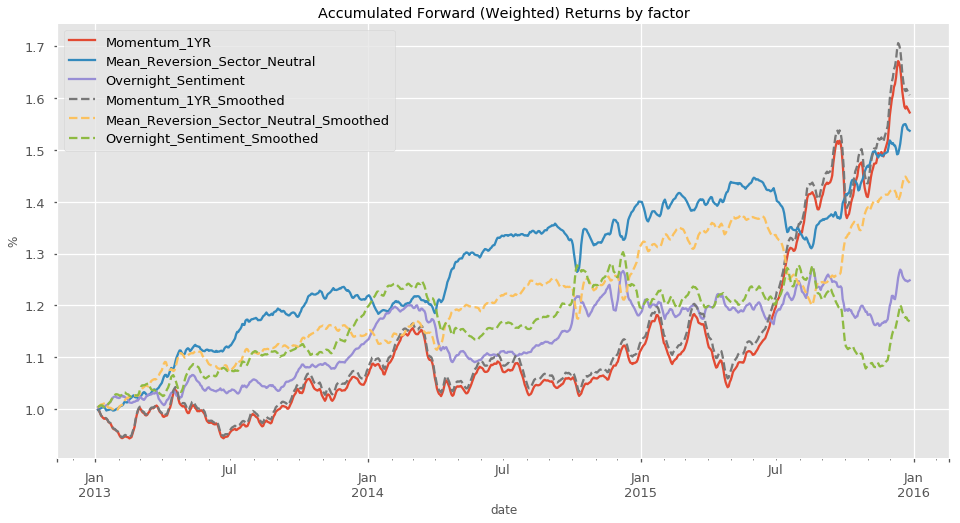

In [35]:
g = cum_rets.plot(y=factor_raw_names, linestyle = '-', figsize=(16,8))
cum_rets.plot(y=factor_smooth_names, linestyle = '--', ax=g)
plt.title('Accumulated Forward (Weighted) Returns by factor')
plt.ylabel("%")
plt.show()

This visualization displays accumulated returns that a portfolio built on top each indicator alpha vector would have yielded. Over a long period of time, 1yr returns are not the best alpha factors, but they end up dominating. Even at some specific points, overnight sentiment may yield the highest returns

## Information Coefficient

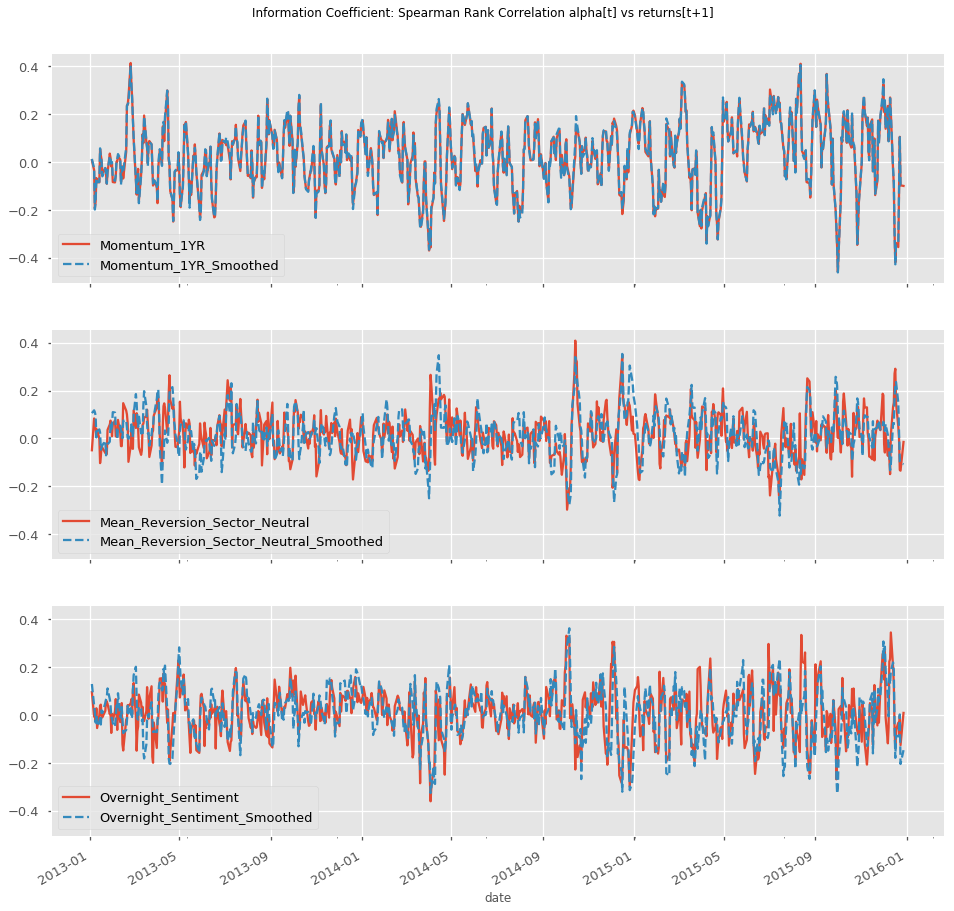

In [36]:
fig, axs = plt.subplots(len(factor_raw_names),1, sharex=True, sharey=True, figsize=(16, 16))

plt.suptitle("Information Coefficient: Spearman Rank Correlation alpha[t] vs returns[t+1]", y=0.92)

for i, (raw, smooth) in enumerate(zip(factor_raw_names, factor_smooth_names)):
    ax = axs[i]
    df_rank_ic.plot(y = raw, ax=ax)
    df_rank_ic.plot(y = smooth, linestyle='--', ax=ax)
    
plt.show()

## Quantile Analysis

In [37]:
df_qr_pbs = df_qr*1e4

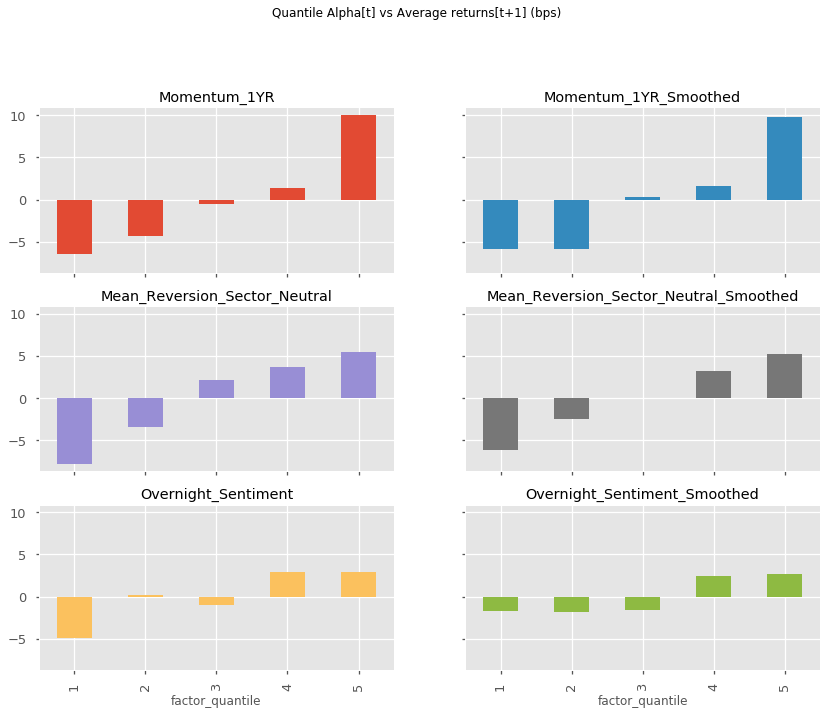

In [38]:
df_qr_pbs.plot.bar(subplots=True, sharey=True, layout=(4,2), figsize=(14, 14), legend=False, title="Quantile Alpha[t] vs Average returns[t+1] (bps)")
plt.show()

1yr momentum and 5d mean reverting displays a monotic relationship, more strong in smoothed versions. However, overnight sentiment returns are not properly distributed throught alpha vector

## Turnover (FRA)

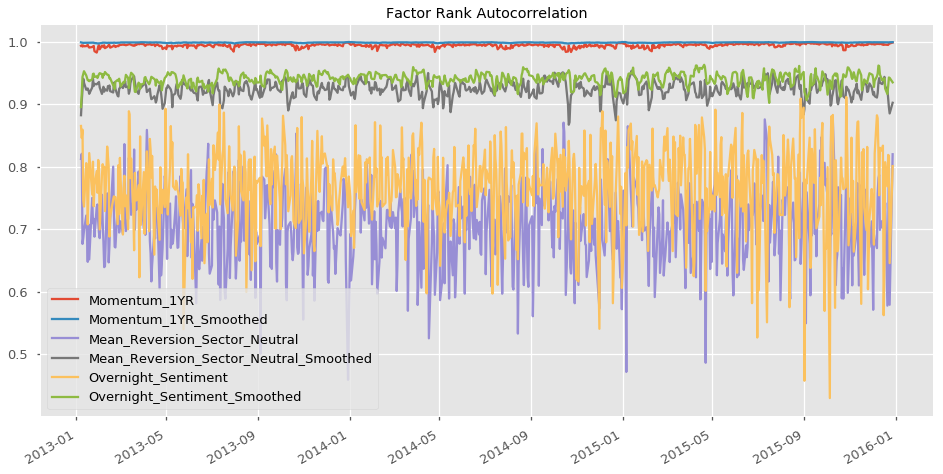

In [39]:
df_fra.plot(title="Factor Rank Autocorrelation", figsize=(16,8))
plt.show()

Autocorrelation analysis shows that 1yr momentum factors alpha vector are very stable (high autocorrelation), on the second place, 5d mean reverting and finally, overnight sentiment may yield alpha vectors that are quite volatile

C:\ProgramData\Anaconda3\envs\quant-ai4trading\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


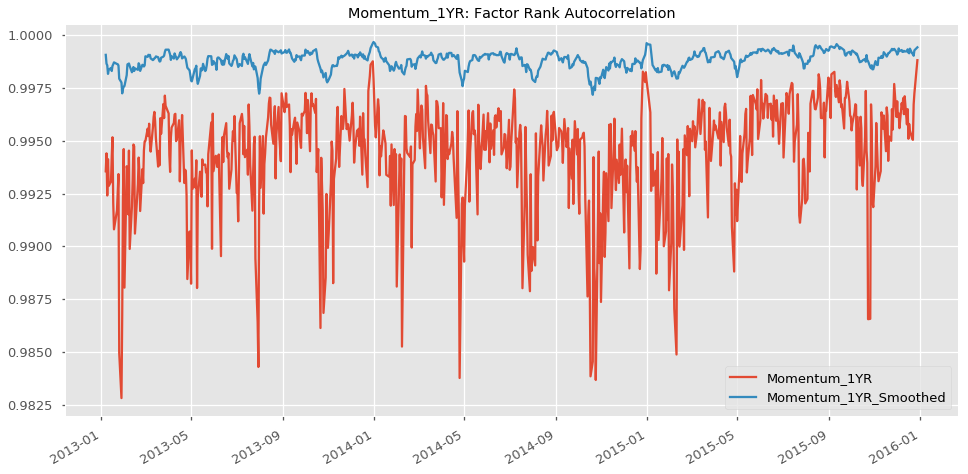

In [40]:
df_fra.plot(y=['Momentum_1YR' ,'Momentum_1YR_Smoothed'], title="Momentum_1YR: Factor Rank Autocorrelation", figsize=(16,8))
plt.show()

In addition, smoothed factor results in a more stable version of the factor, due to a higher autocorrelation among daily alpha factors yielded from 1yr momentum factor